In [1]:
from sys import path
path.append('..')
from clearsky.main import IterativeClearSky
from clearsky.utilities import CONFIG1
import s3fs
import pandas as pd
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
import seaborn as sns
from cvxpy import SolverError
sns.set(context='talk', style='darkgrid', palette='colorblind')
%matplotlib inline
TZ_LOOKUP = {
    'America/Anchorage': 9,
    'America/Chicago': 6,
    'America/Denver': 7,
    'America/Los_Angeles': 8,
    'America/New_York': 5,
    'America/Phoenix': 7,
    'Pacific/Honolulu': 10
}
from datetime import datetime

In [2]:
def load_sys(n=None, idnum=None, local=True):
    if local:
        base = '../data/PVO/'
    if not local:
        base = 's3://pvinsight.nrel/PVO/'
    meta = pd.read_csv('../data/PVO/sys_meta.csv')
    if n is not None:
        idnum = meta['ID'][n]
    elif idnum is not None:
        n = meta[meta['ID'] == idnum].index[0]
    else:
        print('must provide index or ID')
        return
    df = pd.read_csv(base+'PVOutput/{}.csv'.format(idnum), index_col=0,
                      parse_dates=[0], usecols=[1, 3])
    tz = meta['TimeZone'][n]
    df.index = df.index.tz_localize(tz).tz_convert('Etc/GMT+{}'.format(TZ_LOOKUP[tz]))   # fix daylight savings
    start = df.index[0]
    end = df.index[-1]
    time_index = pd.date_range(start=start, end=end, freq='5min')
    df = df.reindex(index=time_index, fill_value=0)
    print(n, idnum)
    return df

In [3]:
n = 572#np.random.randint(642)
idnum = 37285
df = load_sys(idnum=idnum, local=False)

414 37285


In [4]:
days = df.resample('D').max().index[1:-1]
start = days[0]
end = days[-1]
print(start.date(), end.date())

2015-05-15 2017-07-30


In [5]:
end - start

Timedelta('807 days 00:00:00')

In [6]:
D = df.loc[start:end].iloc[:-1].values.reshape(288, -1, order='F')
ics = IterativeClearSky(D)
ics.fixedTimeStamps

False

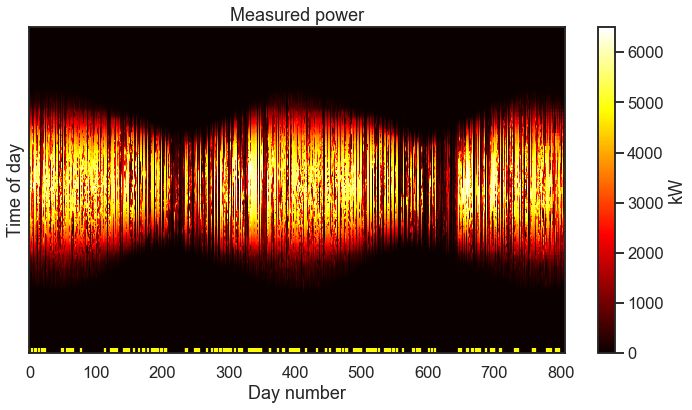

In [7]:
_ = ics.plot_D(show_days=True)

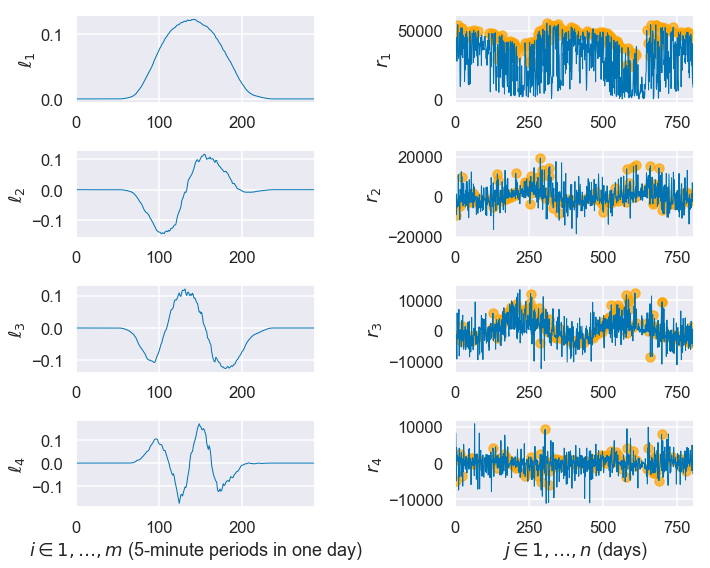

In [8]:
_ = ics.plot_singular_vectors(show_days=True)

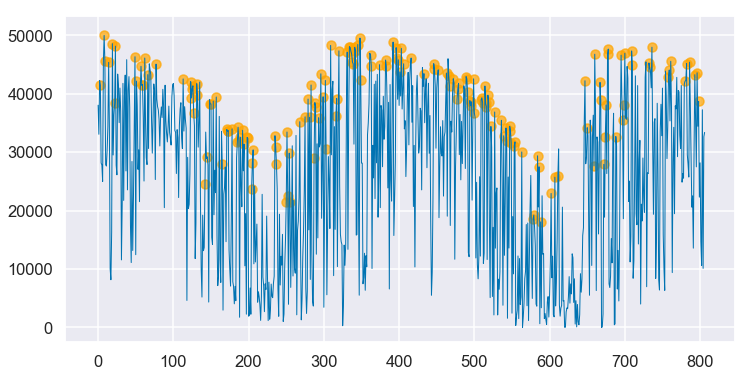

In [9]:
_ = ics.plot_energy()

In [10]:
ics.minimize_objective(**CONFIG1)

starting at 1102507994.741 [2464509.605114313, 758.1123271516393, 906771836.7264886, 193270890.29733223]
iteration 1: 1481217.421 [1.35768441e+06 7.90521000e+02 1.22742490e+05 1.00000000e-03]
iteration 2: 1179016.853 [1.06512472e+06 1.05130900e+03 1.12840816e+05 6.00000000e-03]
iteration 3: 1126097.341 [1.01160167e+06 1.10934500e+03 1.13386316e+05 6.00000000e-03]
iteration 4: 1114098.136 [1.00047264e+06 1.02576300e+03 1.12599713e+05 2.20000000e-02]
iteration 5: 1108755.330 [9.95576911e+05 1.03340600e+03 1.12144996e+05 1.80000000e-02]
Minimization complete in 1.36 minutes


In [11]:
print(np.round((
    ics.residuals_median,
    ics.residuals_variance,
    ics.residual_l0_norm
), 3), ics.isProblemStatusError, ics.isSolverError, ics.f1Increase, ics.objIncrease)

[0.111 0.092 0.054] False False False False


In [12]:
ics.D.shape[1]

807

In [13]:
np.sum(ics.weights > 1e-1)

171

Here is the estimated degradation rate (year on year energy-yield) for the system:

In [14]:
ics.beta.value

array(-0.00070534)

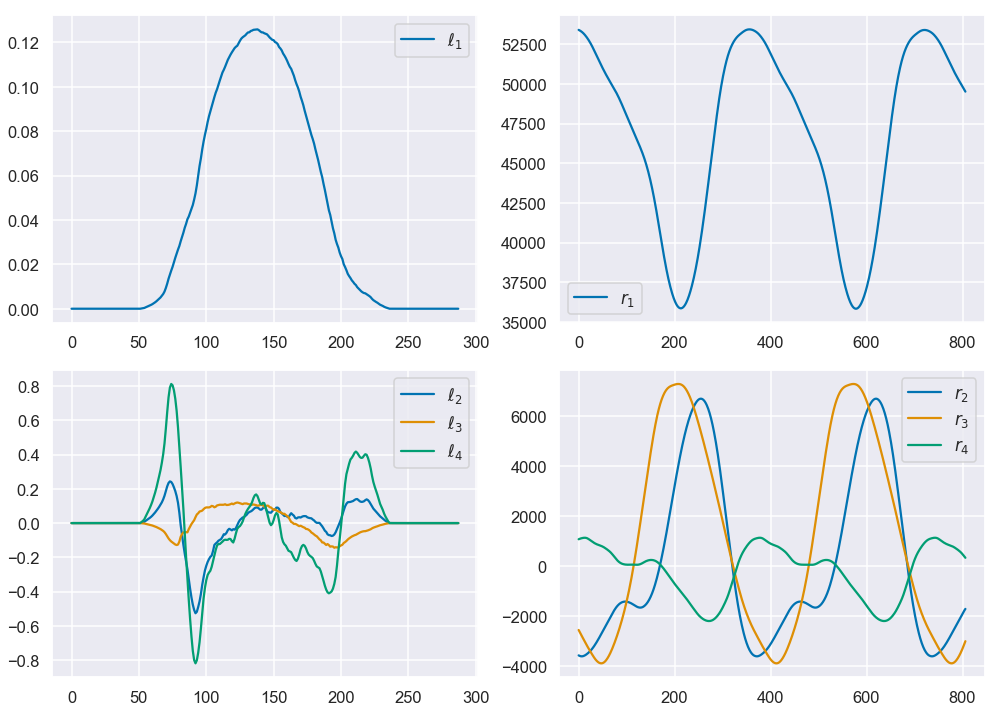

In [15]:
_ = ics.plot_LR()

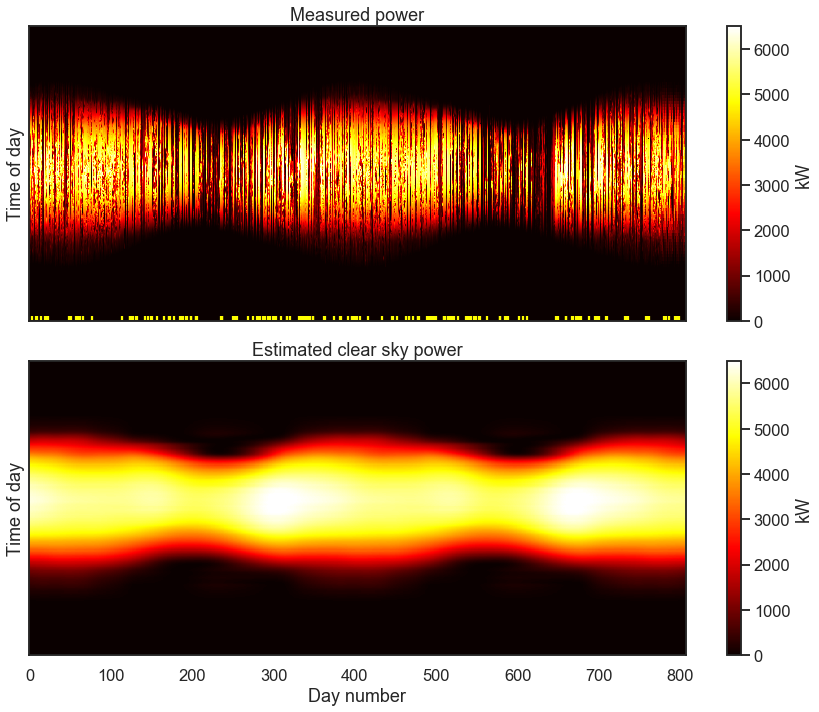

In [16]:
_ = ics.plot_measured_clear(figsize=(12, 10), show_days=True)

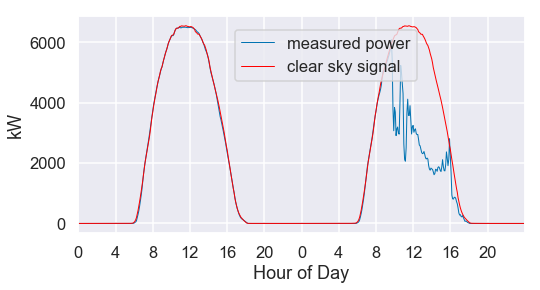

In [30]:
_ = ics.ts_plot(309)

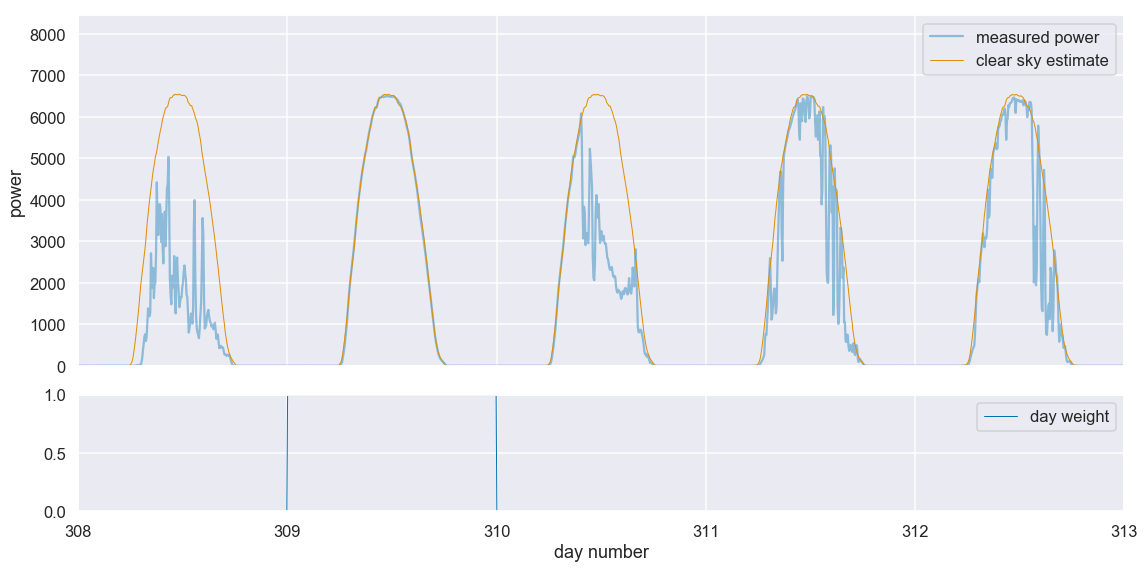

In [29]:
_ = ics.ts_plot_with_weights(308)

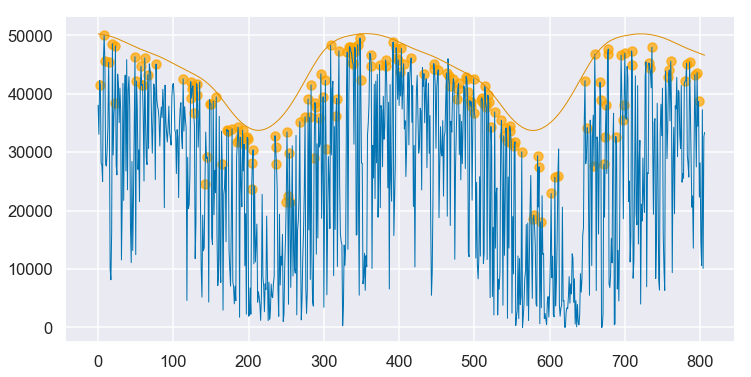

In [19]:
_ = ics.plot_energy(show_clear=True)

## Extra notes and scratch work

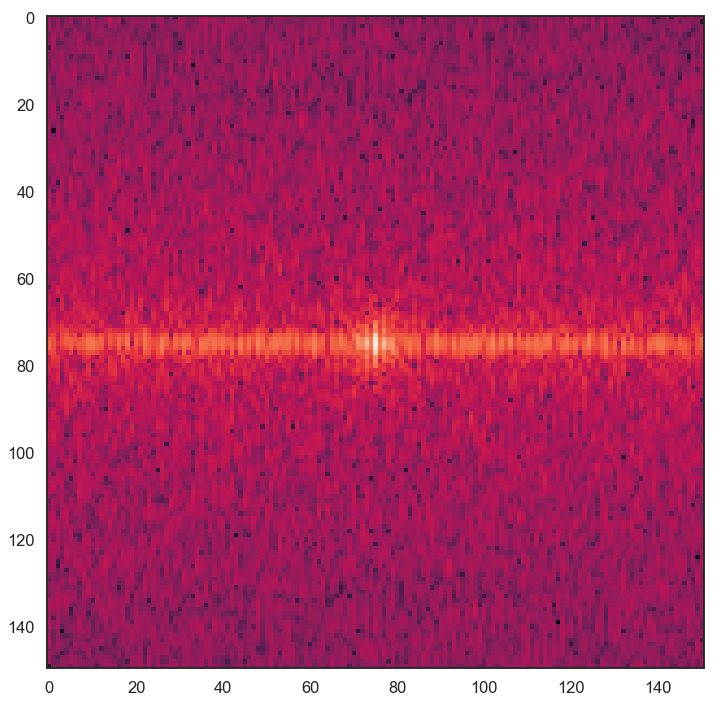

In [20]:
FS = fft2(D)
with sns.axes_style("white"):
    m, n = D.shape
    i = int(m / 2 - 75)
    j = int(n / 2 - 75)
    plt.figure(figsize=(12,12))
    plt.imshow(np.log(np.abs(np.fft.fftshift(FS)[i:-i, j:-j])**2))

In [21]:
fltr = np.zeros_like(D, dtype=np.float)
m, n = D.shape
c = (m // 2, n // 2)
r = 25
if m % 2 == 0:
    di = 0
else:
    di = 1
if n % 2 == 0:
    dj = 0
else:
    dj = 1
y, x = np.ogrid[-c[0]:c[0]+di, -c[1]:c[1]+dj]
mask = x ** 2 + y ** 2 <= r ** 2
fltr[mask] = 1
FS_filtered = fftshift(np.multiply(fftshift(FS), fltr))
D_filtered = np.abs(ifft2(FS_filtered))

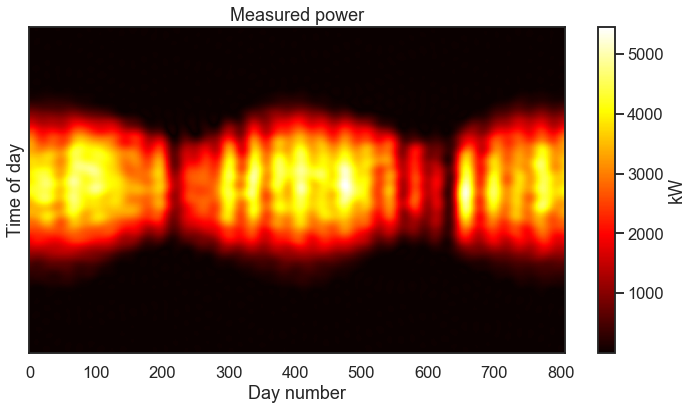

In [22]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6), sharex=True)
    foo = ax.imshow(D_filtered, cmap='hot', interpolation='none', aspect='auto')
    #plt.colorbar(label='kW')
    ax.set_title('Measured power')
    plt.colorbar(foo, ax=ax, label='kW')
    ax.set_xlabel('Day number')
    ax.set_yticks([])
    ax.set_ylabel('Time of day')